In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from pandas import DataFrame
from datetime import timedelta
import datetime
import yfinance as yf
import missingno as msno
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Activation, Dense
from keras.layers import concatenate
import itertools
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
import math
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
sns.set(style="darkgrid")

# 1. Data import & preprocessing #

## 1.1 Import economic data ##

In [2]:
ex_rate = pd.read_csv('Exchange_daily.csv', thousands=',')
trade = pd.read_csv('trade.csv',thousands=',')
leading = pd.read_csv('Leading.csv')
interest = pd.read_csv('Interest.csv')
leading_us = leading[leading.Country=='United States']
leading_korea = leading[leading.Country=='Korea']

## 1.2 Data preprocessing ##

### 1.2.1 Select variable from data and change columns name ###

In [3]:
interest = interest[['DATE','INTDSRUSM193N']]
leading_us = leading_us[['Time','Value']]
leading_korea = leading_korea[['Time','Value']]
ex_rate = ex_rate[['Date','Price']]
trade_balance = trade[['Month','Balance']]
exports = trade[['Month','Exports']]
imports = trade[['Month','Imports']]

In [4]:
trade_balance.columns=['Date','Balance']
exports.columns=['Date','Exports']
imports.columns=['Date','Imports']
interest.columns = ['Date','interest']
leading_us.columns = ['Date','leading_us']
leading_korea.columns = ['Date','leading_korea']
ex_rate.columns = ['Date','exchange_rate']

### 1.2.2 Change datatype of 'Date' variable ###

In [5]:
trade_balance['Date'] = pd.to_datetime(trade_balance['Date'])
exports['Date'] = pd.to_datetime(exports['Date'])
imports['Date'] = pd.to_datetime(imports['Date'])
interest['Date'] = pd.to_datetime(interest['Date'])
leading_us['Date'] = pd.to_datetime(leading_us['Date'])
leading_korea['Date'] = pd.to_datetime(leading_korea['Date'])
ex_rate['Date'] = pd.to_datetime(ex_rate['Date'])


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

### 1.2.3 Aggregate 'Exchange Rate' variable to monthly average ### 

In [6]:
ex_rate.set_index(ex_rate['Date'], inplace=True)
ex_rate = ex_rate.drop('Date', 1)
ex_rate_month = ex_rate.resample('MS', how={'monthly':np.mean}).fillna(0)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\resample.py:956: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  r = r.aggregate(how)


### 1.2.4 Merge every data to one data frame ###

In [7]:
data1 = pd.merge(ex_rate_month,interest,on='Date')
data1 = pd.merge(data1,leading_us,on='Date')
data1 = pd.merge(data1,leading_korea,on='Date')
data1 = pd.merge(data1,exports,on='Date')
data1 = pd.merge(data1,imports,on='Date')
data1 = pd.merge(data1,trade_balance,on='Date')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


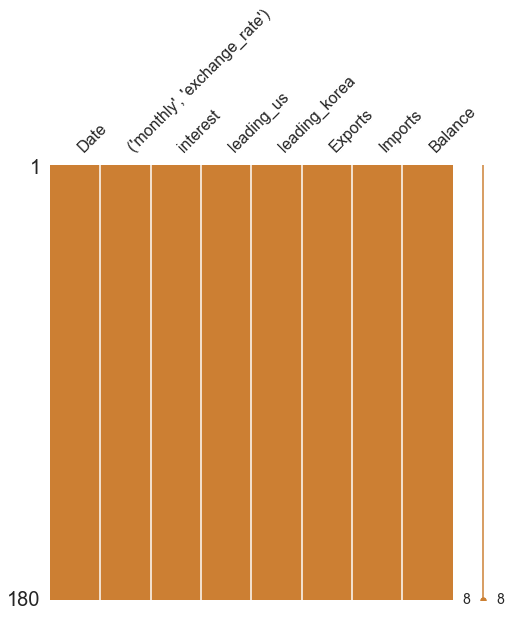

In [8]:
msno.matrix(df=data1, figsize =(8,8), color = (0.8, 0.5, 0.2))

In [9]:
data1.columns=['Date','ex_rate','interest','leading_us','leading_korea','Exports','Imports','Trade Balance']

In [10]:
data1

,Date,ex_rate,interest,leading_us,leading_korea,Exports,Imports,Trade Balance
0,2005-01-01,1038.380952,3.25,100.45080,99.89162,2214.7,4124.0,-1909.2
1,2005-02-01,1023.217500,3.50,100.38210,99.94411,2242.5,3410.6,-1168.1
2,2005-03-01,1008.408696,3.75,100.30400,100.00670,2371.7,3695.9,-1324.2
3,2005-04-01,1009.923810,3.75,100.24810,100.06410,2125.6,3464.7,-1339.1
4,2005-05-01,1001.750000,4.00,100.23570,100.14340,2168.8,3627.2,-1458.4
...,...,...,...,...,...,...,...,...
175,2019-08-01,1210.757727,2.75,98.83972,98.91964,4656.4,6779.2,-2122.8
176,2019-09-01,1195.506190,2.50,98.84105,98.96030,4522.0,5619.8,-1097.8
177,2019-10-01,1183.557826,2.25,98.91140,99.09174,4676.3,6539.3,-1863.1
178,2019-11-01,1168.797143,2.25,99.04106,99.30226,4711.0,6143.7,-1432.8


# 2. EDA #

### 2.1 Trade balance including Exports and Imports ###

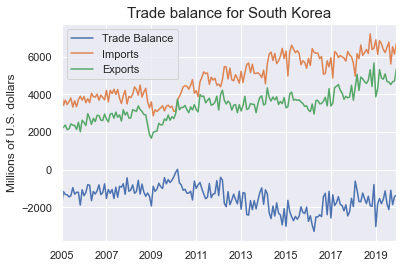

In [11]:
data1.plot(x='Date',y=['Trade Balance','Imports','Exports'])
plt.title("Trade balance for South Korea", fontsize=15)
plt.xlabel('')
plt.ylabel('Millions of U.S. dollars',position=(0.1,0.5))
plt.savefig('2Trade balance.png')

### 2.2  Exchange rates ###

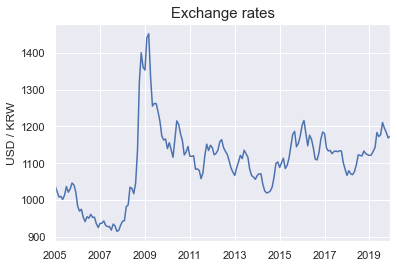

In [12]:
data1.plot(x='Date',y=['ex_rate'],legend=None)
plt.title("Exchange rates", fontsize=15)
plt.xlabel('')
plt.ylabel('USD / KRW')
plt.savefig('3Exchange rate.png')

### 2.3 U.S. interest rates ###

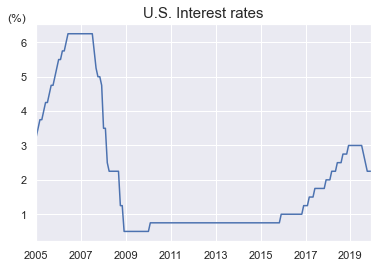

In [187]:
data1.plot(x='Date',y=['interest'],legend=None)
plt.title("U.S. Interest rates", fontsize=15)
plt.xlabel('')
plt.ylabel('(%)',rotation=0,position=(0.5,1))
plt.savefig('3Interest rate.png')

### 2.4 U.S. Leading indicator and South Korea Leading indicator ###

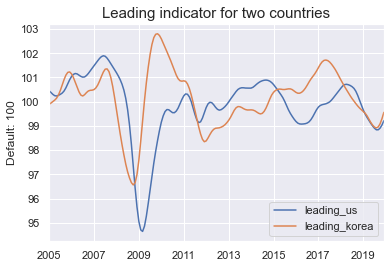

In [13]:
data1.plot(x='Date',y=['leading_us','leading_korea'])
plt.title("Leading indicator for two countries", fontsize=15)
plt.xlabel('')
plt.ylabel('Default: 100',position=(0.5,0.5))
plt.savefig('4Leading indicators.png')

### 2.5 Decide 'Date' variable as index ###

In [14]:
data1.set_index(data1['Date'], inplace=True)
data1 = data1.drop('Date', 1)

### 2.6 Remove Imports and Exports from data ###

In [15]:
trade_balance=data1[['ex_rate','interest','leading_us','leading_korea','Trade Balance']]

values = trade_balance.values
# specify columns to plot
groups = [0,1,2,3,4]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(trade_balance.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

# 3. Analytics #

## 3.1 Granger Causality test ##

In [17]:
def adf_check(tf):
    result = adfuller(tf)
    if result[1] <= 0.05:
        print('Stationary {}'.format(result[1]))
    else:
        print('Non-stationary {}'.format(result[1]))

### 3.1.1 Check stationary of variables ###

In [18]:
adf_check(trade_balance['ex_rate'])

Stationary 0.049121618135553054


In [19]:
adf_check(trade_balance['interest'])

Stationary 0.027338467651005012


In [20]:
adf_check(trade_balance['leading_us'])

Stationary 0.007294571220351389


In [21]:
adf_check(trade_balance['leading_korea'])

Stationary 0.0038510851080876844


In [22]:
adf_check(trade_balance['Trade Balance'])

Non-stationary 0.5987424802000696


Because trade balance variables is not stationary, we have to used first differenced variable

In [23]:
trade_balance['1st_diff'] = trade_balance['Trade Balance'] - trade_balance['Trade Balance'].shift(1)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [24]:
trade_balance_1=trade_balance[1:]

In [25]:
adf_check(trade_balance_1['1st_diff'])

Stationary 3.600605635346006e-05


After first differencing, trade_balance also become stationary

### 3.1.2 Granger Causality test ###

In [26]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df


In [27]:
grangers_causation_matrix(trade_balance_1, variables = trade_balance_1.columns)     

,ex_rate_x,interest_x,leading_us_x,leading_korea_x,Trade Balance_x,1st_diff_x
ex_rate_y,1.0000,0.0000,0.0000,0.0000,0.1543,0.0943
interest_y,0.0463,1.0000,0.0022,0.0004,0.1629,0.5770
leading_us_y,0.0064,0.0000,1.0000,0.0000,0.0044,0.3200
leading_korea_y,0.0000,0.0013,0.0000,1.0000,0.1453,0.5972
Trade Balance_y,0.2088,0.1091,0.0179,0.3853,1.0000,0.0000
1st_diff_y,0.1955,0.3239,0.0101,0.3277,0.0002,1.0000


values = trade_balance.values
# specify columns to plot
groups = [ 2,  4]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(trade_balance.columns[group], y=0.1, loc='right')
    i += 1
pyplot.show()

### 3.1.3 Plot meaningful variable based on Granger Causality test ###

In [29]:
def min_max_normalize(lst):
    normalized = []
    
    for value in lst:
        normalized_num = (value - min(lst)) / (max(lst) - min(lst))
        normalized.append(normalized_num)
    
    return normalized

In [30]:
def z_score_normalize(lst):
    normalized = []
    for value in lst:
        normalized_num = (value - np.mean(lst)) / np.std(lst)
        normalized.append(normalized_num)
    return normalized

In [31]:
min_max_scatter = trade_balance
z_score_scatter = trade_balance

In [32]:
min_max_scatter['Normalized Trade Balance'] = min_max_normalize(min_max_scatter['Trade Balance'])
min_max_scatter['Normalized leading_US'] = min_max_normalize(min_max_scatter['leading_us'])
min_max_scatter = min_max_scatter[['Normalized leading_US','Normalized Trade Balance']]

In [33]:
z_score_scatter['Normalized Trade Balance'] = z_score_normalize(z_score_scatter['Trade Balance'])
z_score_scatter['Normalized leading_US'] = z_score_normalize(z_score_scatter['leading_us'])
z_score_scatter = z_score_scatter[['Normalized leading_US','Normalized Trade Balance']]

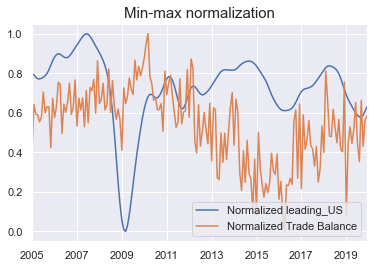

In [34]:
min_max_scatter.plot()
plt.title("Min-max normalization", fontsize=15)
plt.xlabel('')
plt.ylabel('')
plt.savefig('5Min-max normalization.png')

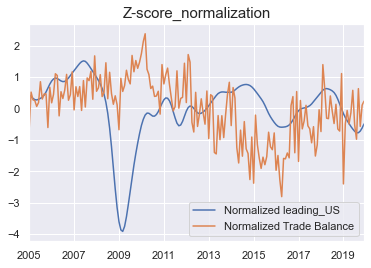

In [35]:
z_score_scatter.plot()
plt.title("Z-score_normalization", fontsize=15)
plt.xlabel('')
plt.ylabel('')
plt.savefig('6Z-score_normalization.png')

### 3.1.4 Final variable selection based on Granger Causality test ###

In [36]:
trade_balance=data1[['leading_us','Trade Balance']]

In [37]:
trade_balance.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 180 entries, 2005-01-01 to 2019-12-01
Data columns (total 2 columns):
leading_us       180 non-null float64
Trade Balance    180 non-null float64
dtypes: float64(2)
memory usage: 4.2 KB


## 3.2 LSTM model ##

### 3.2.1 Prepare modeling ###

In [39]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [40]:
values = trade_balance.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[2]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)   var2(t)
1   0.800705   0.417273  0.641767
2   0.791233   0.641767  0.594481
3   0.780465   0.594481  0.589967
4   0.772758   0.589967  0.553829
5   0.771049   0.553829  0.577790


### 3.2.2 Prepare dataset ###

In [41]:
# split into train, valid, and test sets
values = reframed.values
n_train_hours = 12*13
train = values[:n_train_hours, :]
valid = values[n_train_hours:n_train_hours+11,:]
test = values[n_train_hours+11:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
valid_X, valid_y = valid[:, :-1], valid[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
valid_X = valid_X.reshape((valid_X.shape[0], 1, valid_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, valid_X.shape, valid_y.shape, test_X.shape, test_y.shape)

(156, 1, 2) (156,) (11, 1, 2) (11,) (12, 1, 2) (12,)


### 3.2.3 Train the model and visualize it ###

Train on 156 samples, validate on 11 samples
Epoch 1/40
 - 0s - loss: 0.5879 - val_loss: 0.5911
Epoch 2/40
 - 0s - loss: 0.5665 - val_loss: 0.5691
Epoch 3/40
 - 0s - loss: 0.5453 - val_loss: 0.5472
Epoch 4/40
 - 0s - loss: 0.5243 - val_loss: 0.5253
Epoch 5/40
 - 0s - loss: 0.5033 - val_loss: 0.5033
Epoch 6/40
 - 0s - loss: 0.4822 - val_loss: 0.4812
Epoch 7/40
 - 0s - loss: 0.4610 - val_loss: 0.4588
Epoch 8/40
 - 0s - loss: 0.4397 - val_loss: 0.4361
Epoch 9/40
 - 0s - loss: 0.4182 - val_loss: 0.4131
Epoch 10/40
 - 0s - loss: 0.3968 - val_loss: 0.3896
Epoch 11/40
 - 0s - loss: 0.3750 - val_loss: 0.3654
Epoch 12/40
 - 0s - loss: 0.3527 - val_loss: 0.3406
Epoch 13/40
 - 0s - loss: 0.3304 - val_loss: 0.3151
Epoch 14/40
 - 0s - loss: 0.3079 - val_loss: 0.2888
Epoch 15/40
 - 0s - loss: 0.2860 - val_loss: 0.2618
Epoch 16/40
 - 0s - loss: 0.2651 - val_loss: 0.2348
Epoch 17/40
 - 0s - loss: 0.2459 - val_loss: 0.2076
Epoch 18/40
 - 0s - loss: 0.2281 - val_loss: 0.1805
Epoch 19/40
 - 0s - loss: 0.

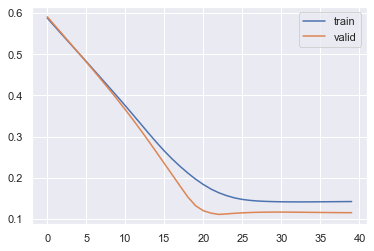

<Figure size 432x288 with 0 Axes>

In [42]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, epochs=40, batch_size=72, validation_data=(valid_X, valid_y), verbose=2, shuffle=False)

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='valid')
pyplot.legend()
pyplot.show()
plt.savefig('7LSTM learning.png')

### 3.2.4 Fit the validation data to the model and calculate RMSE ###

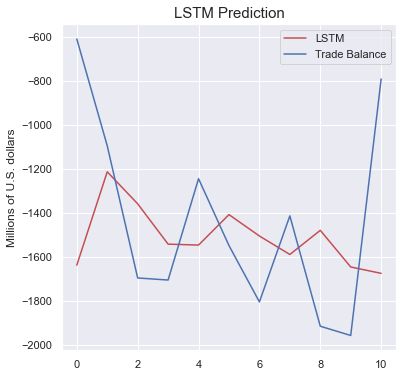

In [43]:
balance_min = min(trade_balance['Trade Balance'])
balance_max = max(trade_balance['Trade Balance'])
balance_min_max = max(trade_balance['Trade Balance'])-min(trade_balance['Trade Balance'])
# make a prediction
y_val = model.predict(valid_X)*balance_min_max+balance_min

plt.figure(figsize=[6,6])
plt.plot(y_val.ravel(),'r-',label='LSTM')
plt.plot(valid_y.ravel()*balance_min_max+balance_min,'b-',label='Trade Balance')
#plt.plot((yhat-test_y).ravel(),'g-',label='diff*10')
plt.legend()
plt.title("LSTM Prediction", fontsize=15)
plt.xlabel('')
plt.ylabel('Millions of U.S. dollars')
plt.savefig('8LSTM prediction.png')

In [44]:
rmse = math.sqrt(mean_squared_error(y_val, valid_y*balance_min_max+balance_min))
rmse

477.41737772955327

### 3.2.5 Forecast after FTA revision ###

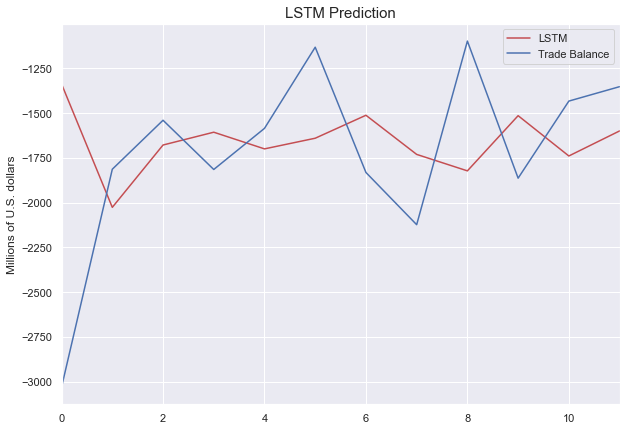

In [45]:

# make a prediction
pred_y = model.predict(test_X)*balance_min_max+balance_min

plt.figure(figsize=[10,7])
plt.xlim(0,11)
plt.plot(pred_y.ravel(),'r-',label='LSTM')
plt.plot(test_y.ravel()*balance_min_max+balance_min,'b-',label='Trade Balance')
#plt.plot((yhat-test_y).ravel(),'g-',label='diff*10')
plt.legend()
plt.title("LSTM Prediction", fontsize=15)
plt.xlabel('')
plt.ylabel('Millions of U.S. dollars')
plt.savefig('9LSTM prediction with test.png')

# 3.3 ARIMA model #

### 3.3.1 Check data ###

In [53]:
data2=trade_balance[['Trade Balance']] 

In [54]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 180 entries, 2005-01-01 to 2019-12-01
Data columns (total 1 columns):
Trade Balance    180 non-null float64
dtypes: float64(1)
memory usage: 2.8 KB


### 3.3.2 Prepare all combination of parameters ###

In [55]:
# Define parameters between 0 and 2
p = d = q = range(0, 2)

# Generate all combinations 
pdq = list(itertools.product(p, d, q))

# Generate all combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


### 3.3.3. Prepare dataset ###

In [62]:
data2_1= data2[['Trade Balance']]

In [63]:
train = data2_1[0:156]
valid = data2_1[156:168]
test = data2_1[168:180]


### 3.3.4 Calculate all combination of parameters ###

In [64]:
warnings.filterwarnings("ignore") 

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2732.9614663459042
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2410.172170757616
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2219.4779747587163
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2027.5800552738347
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2235.747441262174
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2205.747900317837
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2039.2734814359972
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2026.783146533005
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2595.447956418653
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2312.563433770766
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2175.136379499033
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1976.9071612283278
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2204.668008945636
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2151.9961238354863
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2002.3694035947335
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1975.9329935678052
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2375.7311858264434
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2174.494793700848
A

### 3.3.5 Build ARIMA model based on best AIC ###

In [65]:
model = sm.tsa.statespace.SARIMAX(train['Trade Balance'],order=(0,1,1),seasonal_order=(0,1,1,12))

### 3.3.6 Fit the train data ###

In [66]:
result = model.fit()

In [67]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                      Trade Balance   No. Observations:                  156
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1055.074
Date:                            Sat, 09 May 2020   AIC                           2116.147
Time:                                    11:55:41   BIC                           2125.036
Sample:                                01-01-2005   HQIC                          2119.759
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5648      0.066     -8.555      0.000      -0.694      -0.435
ma.S.L12      -0.7877      0.071    -11.049      0.000      -0.927      -0.648
sigma2      1.408e+05    1.8e+04      7.841      0.000    1.06e+05    1.76e+05
===================================================================================
Ljung-Box (Q):                       38.39   Jarque-Bera (JB):                 1.31
Prob(Q):                              0.54   Prob(JB):                         0.52
Heteroskedasticity (H):               1.73   Skew:                             0.22
Prob(H) (two-sided):                  0.06   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3.3.7 Check remain features for residuals ###

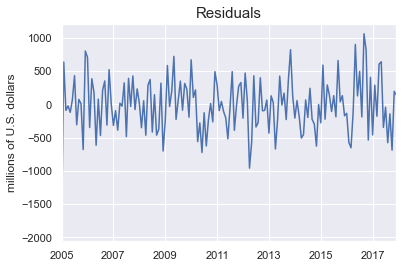

In [68]:
result.resid.plot()
plt.title("Residuals", fontsize=15)
plt.xlabel('')
plt.ylabel('millions of U.S. dollars')
plt.savefig('11ARIMA_train_resid.png')

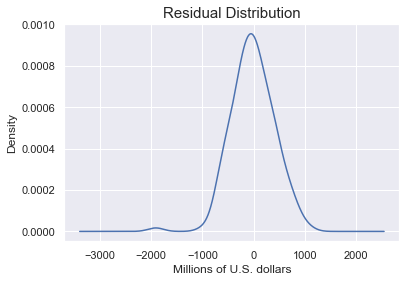

In [69]:
result.resid.plot(kind='kde')
plt.title("Residual Distribution", fontsize=15)
plt.xlabel('Millions of U.S. dollars')
plt.ylabel('Density')
plt.savefig('11ARIMA_train_resid distribution.png')

### 3.3.8 Fit validation dataset and calculate RMSE ###

In [70]:
data2['valid'] = result.predict(start=156,end=168, dynamic=True)


In [71]:
data2_valid=data2[['Trade Balance','valid']]
data2_valid=data2_valid[156:168]
data2_valid

,Trade Balance,valid
Date,,
2018-01-01,-1967.6,-2476.781169
2018-02-01,-610.9,-1671.028128
2018-03-01,-1096.0,-1977.803144
2018-04-01,-1696.5,-2370.943205
2018-05-01,-1705.9,-2288.157450
2018-06-01,-1245.7,-2147.229588
2018-07-01,-1549.3,-2327.901050
2018-08-01,-1805.2,-2176.123783
2018-09-01,-1414.5,-1992.132217


In [72]:
rmse = math.sqrt(mean_squared_error(data2_valid['Trade Balance'], data2_valid['valid']))
rmse

693.2872798551784

### 3.3.9 Train all previous data while maintaining parameters ###

In [73]:
data2_2= data2[['Trade Balance']]
train_valid = data2_2[0:168]
test = data2_2[168:180]

In [74]:
model = sm.tsa.statespace.SARIMAX(train_valid['Trade Balance'],order=(0,1,1),seasonal_order=(0,1,1,12))

In [75]:
result = model.fit()

In [76]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                      Trade Balance   No. Observations:                  168
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1143.056
Date:                            Sat, 09 May 2020   AIC                           2292.111
Time:                                    11:57:31   BIC                           2301.242
Sample:                                01-01-2005   HQIC                          2295.820
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5432      0.066     -8.238      0.000      -0.672      -0.414
ma.S.L12      -0.7859      0.067    -11.735      0.000      -0.917      -0.655
sigma2      1.405e+05   1.72e+04      8.172      0.000    1.07e+05    1.74e+05
===================================================================================
Ljung-Box (Q):                       43.86   Jarque-Bera (JB):                 1.52
Prob(Q):                              0.31   Prob(JB):                         0.47
Heteroskedasticity (H):               1.75   Skew:                             0.22
Prob(H) (two-sided):                  0.05   Kurtosis:                         2.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3.3.10 Forecast after FTA revision with test data ###

In [77]:
data2['ARIMA'] = result.predict(start=168,end=180, dynamic=True)

In [78]:
data2_ARIMA = data2[['Trade Balance','ARIMA']][168:180]

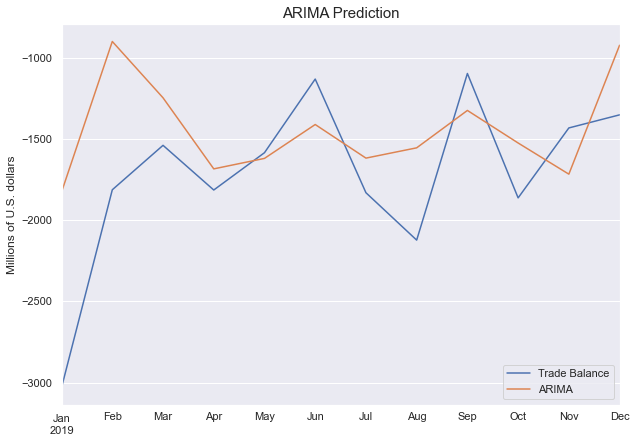

In [79]:
data2_ARIMA[['Trade Balance','ARIMA']].plot(figsize=(10,7))
plt.title("ARIMA Prediction", fontsize=15)
plt.xlabel('')
plt.ylabel('Millions of U.S. dollars')
plt.savefig('13ARIMA_test_forecast.png')

## 3.4 Vector AR model ##

### 3.4.1 Prepare train and validation dataset ###

In [80]:
data3=data1[['ex_rate','interest','leading_us','leading_korea','Trade Balance']]


In [81]:
data3_val = data3[['leading_us','Trade Balance']]
data3_val = data3_val[:168]

In [82]:
nobs = 12
df_train, df_test = data3_val[0:-nobs], data3_val[-nobs:]

# Check size
print(df_train.shape)  
print(df_test.shape)  

(156, 2)
(12, 2)


### 3.4.2 Check stationary of variables ###

In [84]:
adf_check(data3_val['Trade Balance'])

Non-stationary 0.6091118255461948


In [85]:
df_differenced = df_train.diff().dropna()

In [86]:
adf_check(df_differenced['leading_us'])

Stationary 0.005757825110911704


In [87]:
adf_check(df_differenced['Trade Balance'])

Stationary 0.00036001951720301565


### 3.4.3 Find parameter based on AIC ###

In [88]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic, '\n')
    

Lag Order = 1
AIC :  6.78899032910347 

Lag Order = 2
AIC :  4.561779682069114 

Lag Order = 3
AIC :  3.7358829326368497 

Lag Order = 4
AIC :  3.6969242789460153 

Lag Order = 5
AIC :  3.6728937687174725 

Lag Order = 6
AIC :  3.6899934840928754 

Lag Order = 7
AIC :  3.7214197716746202 

Lag Order = 8
AIC :  3.7509103022842916 

Lag Order = 9
AIC :  3.780927018448429 



### 3.4.4 Fit the train data based on best AIC ###

In [89]:
model_fitted = model.fit(5)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 09, May, 2020
Time:                     12:01:41
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    4.11445
Nobs:                     150.000    HQIC:                   3.85229
Log likelihood:          -679.149    FPE:                    39.3864
AIC:                      3.67289    Det(Omega_mle):         34.1883
--------------------------------------------------------------------
Results for equation leading_us
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.000022         0.001140            0.019           0.984
L1.leading_us            2.814034         0.084670           33.235           0.000
L1.Trade Balance        -0.000002         0

### 3.4.5 Check remain features with Durbin Watson Statistic ###

In [91]:
out = durbin_watson(model_fitted.resid)

print(out)

[1.97610868 1.98025545]


If DW is near 2, it means there's no remain features

### 3.4.6 Fit validation data  ###

In [92]:
lag_order = model_fitted.k_ar
print(lag_order)  

5


In [93]:
forecast_input = df_differenced.values[-lag_order:]
forecast_input

array([[ 7.352e-02, -2.832e+02],
       [ 9.420e-02,  3.272e+02],
       [ 1.015e-01, -5.952e+02],
       [ 9.820e-02,  2.265e+02],
       [ 9.800e-02,  7.115e+02]])

In [94]:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=data3_val.index[-nobs:], columns=data3_val.columns + '_1d')
df_forecast

,leading_us_1d,Trade Balance_1d
Date,,
2018-01-01,0.101282,-521.949885
2018-02-01,0.103950,61.322930
2018-03-01,0.099973,152.263511
2018-04-01,0.087238,-232.732320
2018-05-01,0.069002,29.953737
2018-06-01,0.048764,161.881955
2018-07-01,0.029225,-170.288750
2018-08-01,0.012873,30.482033
2018-09-01,0.000497,39.373737


### 3.4.7 Because first differecing, restore to original value ###

In [95]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [96]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)    
df_results.loc[:, ['leading_us_forecast', 'Trade Balance_forecast']]

,leading_us_forecast,Trade Balance_forecast
Date,,
2018-01-01,100.558682,-2047.649885
2018-02-01,100.662632,-1986.326955
2018-03-01,100.762605,-1834.063444
2018-04-01,100.849843,-2066.795764
2018-05-01,100.918845,-2036.842026
2018-06-01,100.967609,-1874.960072
2018-07-01,100.996833,-2045.248821
2018-08-01,101.009707,-2014.766788
2018-09-01,101.010204,-1975.393051


### 3.4.8 Calculate RMSE ###

In [98]:
def forecast_accuracy(forecast, actual):
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
          
    return({'rmse':rmse})

print('Forecast Accuracy of: Trade Balance')
accuracy_prod = forecast_accuracy(df_results['Trade Balance_forecast'].values, df_test['Trade Balance'])
accuracy_prod


Forecast Accuracy of: Trade Balance


{'rmse': 658.5400823816899}

### 3.4.9 Train all previous data ###

In [99]:
data3 = data1[['leading_us','Trade Balance']]

In [100]:
nobs = 12
df_train, df_test = data3[0:-nobs], data3[-nobs:]

# Check size
print(df_train.shape)  
print(df_test.shape)  

(168, 2)
(12, 2)


In [101]:
df_differenced = df_train.diff().dropna()


In [102]:
adf_check(df_differenced['leading_us'])

Stationary 0.003669253327519878


In [103]:
adf_check(df_differenced['Trade Balance'])

Stationary 0.00018837819070330008


In [104]:
model_fitted = model.fit(5)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 09, May, 2020
Time:                     12:05:55
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    4.11445
Nobs:                     150.000    HQIC:                   3.85229
Log likelihood:          -679.149    FPE:                    39.3864
AIC:                      3.67289    Det(Omega_mle):         34.1883
--------------------------------------------------------------------
Results for equation leading_us
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.000022         0.001140            0.019           0.984
L1.leading_us            2.814034         0.084670           33.235           0.000
L1.Trade Balance        -0.000002         0

### 3.4.10 Check remain features for residuals ###

In [105]:
out = durbin_watson(model_fitted.resid)

print(out)

[1.97610868 1.98025545]


### 3.4.11 Forecast after FTA revision ###

In [106]:
lag_order = model_fitted.k_ar
print(lag_order)  

5


In [107]:
forecast_input = df_differenced.values[-lag_order:]
forecast_input

array([[-7.1500e-02, -2.5590e+02],
       [-1.1660e-01,  3.9070e+02],
       [-1.7000e-01, -5.0120e+02],
       [-2.0190e-01, -4.2000e+01],
       [-2.1219e-01,  1.1653e+03]])

In [108]:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=data3.index[-nobs:], columns=data3.columns + '_1d')
df_forecast

,leading_us_1d,Trade Balance_1d
Date,,
2019-01-01,-0.204949,-962.668142
2019-02-01,-0.182258,230.428854
2019-03-01,-0.150940,136.072916
2019-04-01,-0.116681,-241.816497
2019-05-01,-0.081327,-13.941099
2019-06-01,-0.047501,316.424256
2019-07-01,-0.018349,-265.520605
2019-08-01,0.004758,109.638143
2019-09-01,0.020177,54.842157


### 3.4.12 Restore first differenced variables ###

In [109]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [110]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)    
df_results.loc[:, ['leading_us_forecast', 'Trade Balance_forecast']]

,leading_us_forecast,Trade Balance_forecast
Date,,
2019-01-01,99.643861,-1755.068142
2019-02-01,99.461603,-1524.639288
2019-03-01,99.310663,-1388.566372
2019-04-01,99.193982,-1630.382869
2019-05-01,99.112655,-1644.323967
2019-06-01,99.065154,-1327.899712
2019-07-01,99.046805,-1593.420317
2019-08-01,99.051564,-1483.782173
2019-09-01,99.071741,-1428.940017


In [111]:
data3['VAR'] = round(df_results["Trade Balance_forecast"])

In [112]:
data3_VAR = data3[['Trade Balance','VAR']][168:180]

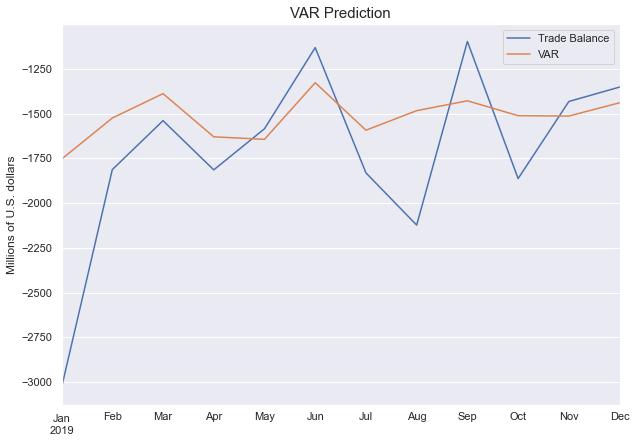

In [113]:
data3_VAR[['Trade Balance','VAR']].plot(figsize=(10,7))
plt.title("VAR Prediction", fontsize=15)
plt.xlabel('')
plt.ylabel('Millions of U.S. dollars')
plt.savefig('14VAR_prediction.png')

# 4. Summary and Paired T-test #

### 4.1 Summary for 3 algorithms ###

In [115]:
data3['ARIMA'] = round(data2['ARIMA'])

In [116]:
data3 = data3[168:]

In [117]:
data3['LSTM'] = [-1339,-2076,-1703,-1628,-1728,-1665,-1530,-1763,-1862,-1533,-1772,-1622]

There's some issue for LSTM model data type. So, I just type LSTM data manually

In [118]:
data3

,leading_us,Trade Balance,VAR,ARIMA,LSTM
Date,,,,,
2019-01-01,99.65370,-3028.9,-1755.0,-1826.0,-1339
2019-02-01,99.48927,-1813.2,-1525.0,-901.0,-2076
2019-03-01,99.35271,-1539.8,-1389.0,-1247.0,-1703
2019-04-01,99.22594,-1814.6,-1630.0,-1685.0,-1628
2019-05-01,99.10625,-1585.1,-1644.0,-1620.0,-1728
2019-06-01,98.99672,-1132.1,-1328.0,-1412.0,-1665
2019-07-01,98.90261,-1831.3,-1593.0,-1618.0,-1530
2019-08-01,98.83972,-2122.8,-1484.0,-1555.0,-1763
2019-09-01,98.84105,-1097.8,-1429.0,-1325.0,-1862


In [120]:
data3 = data3[['Trade Balance','VAR','ARIMA','LSTM']]

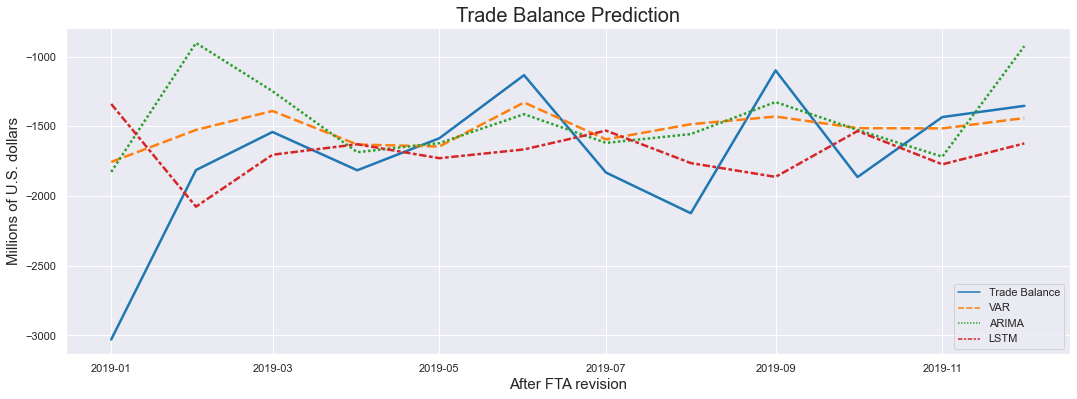

In [123]:
plt.figure(figsize=(18,6))
b = sns.lineplot(data=data3, sort=True, linewidth=2.5,
            palette="tab10")

b.axes.set_title("Trade Balance Prediction",fontsize=20)
b.set_xlabel('After FTA revision', fontsize=15)
b.set_ylabel("Millions of U.S. dollars",fontsize=15)
plt.savefig('15compare3algorithms.png')

### 4.2 Compare annual mean ###

In [124]:
print('Trade Balance 2019 mean: ',round(data3['Trade Balance'].mean()))
print('LSTM          2019 mean: ',round(data3['LSTM'].mean()))
print('ARIMA         2019 mean: ',round(data3['ARIMA'].mean()))
print('VAR           2019 mean: ',round(data3['VAR'].mean()))

Trade Balance 2019 mean:  -1718
LSTM          2019 mean:  -1685
ARIMA         2019 mean:  -1446
VAR           2019 mean:  -1520


### 4.3 Paired T-test for each algorithm ###

In [125]:
stats.ttest_rel(data3['LSTM'],data3['Trade Balance'])

Ttest_relResult(statistic=0.17972082678180104, pvalue=0.8606396085453034)

In [126]:
stats.ttest_rel(data3['ARIMA'],data3['Trade Balance'])

Ttest_relResult(statistic=2.024896398883517, pvalue=0.06784328075727496)

In [127]:
stats.ttest_rel(data3['VAR'],data3['Trade Balance'])

Ttest_relResult(statistic=1.5860199068879204, pvalue=0.14104185865155455)